In [5]:
from time import time
import numpy as np 
import matplotlib.pyplot as plt
from rtmag.paper.load import load_input_label, MyModel

In [6]:
input_files, label_files = load_input_label("/mnt/f/isee_dataset/11158")
len(input_files), len(label_files)

(66, 66)

In [7]:
idx = 13
input_files[idx], label_files[idx]

(PosixPath('/mnt/f/isee_dataset/11158/input/input_11158_20110214_000000.npz'),
 PosixPath('/mnt/f/isee_dataset/11158/label/label_11158_20110214_000000.npz'))

In [8]:
labels = np.load(label_files[idx])

In [10]:
B = labels["label"][:, :-1, :-1, :-1]
B.shape

(3, 512, 256, 256)

In [11]:
Bp = labels["pot"][:, :-1, :-1, :-1]
Bp.shape

(3, 512, 256, 256)

In [16]:
vmm = 2000

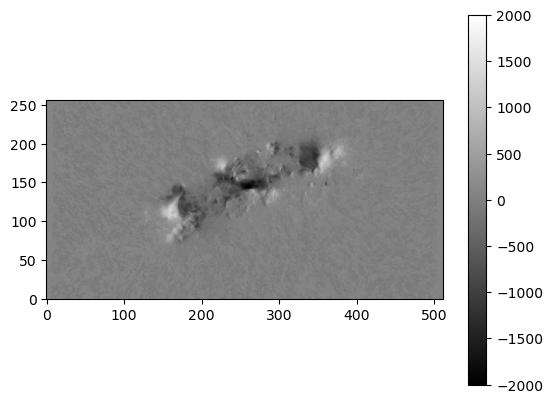

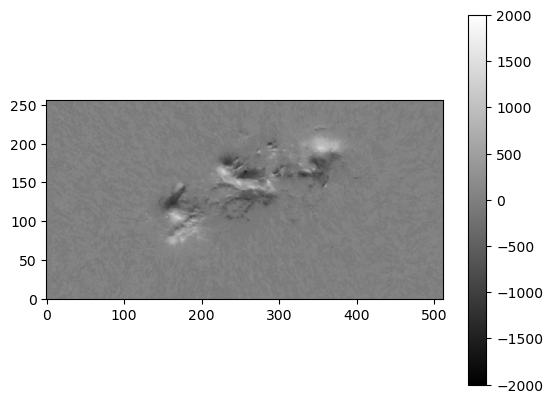

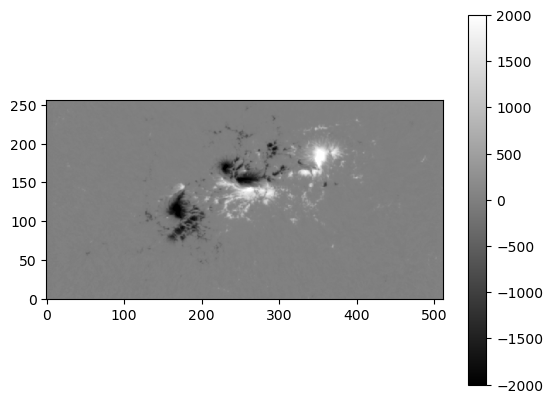

In [17]:
plt.imshow(B[0, :, :, 0].T, origin="lower", cmap="gray", vmin=-vmm, vmax=vmm)
plt.colorbar()
plt.show()

plt.imshow(B[1, :, :, 0].T, origin="lower", cmap="gray", vmin=-vmm, vmax=vmm)
plt.colorbar()
plt.show()

plt.imshow(B[2, :, :, 0].T, origin="lower", cmap="gray", vmin=-vmm, vmax=vmm)
plt.colorbar()
plt.show()

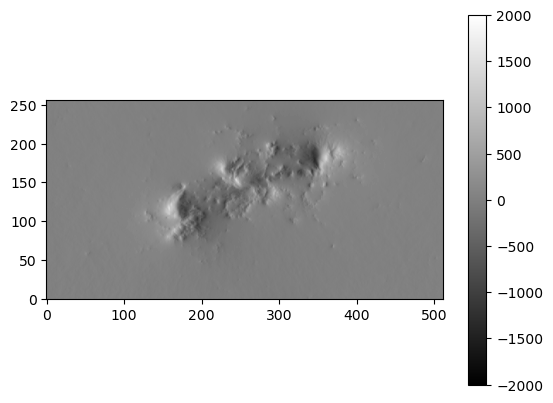

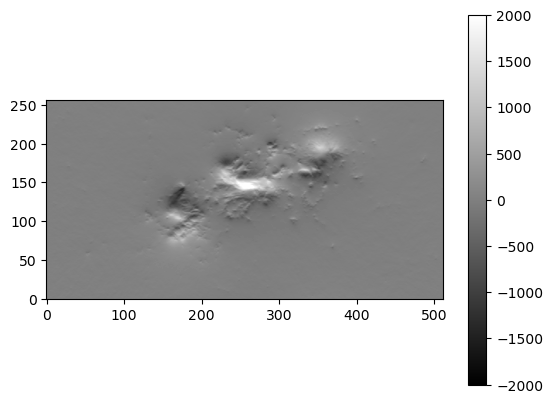

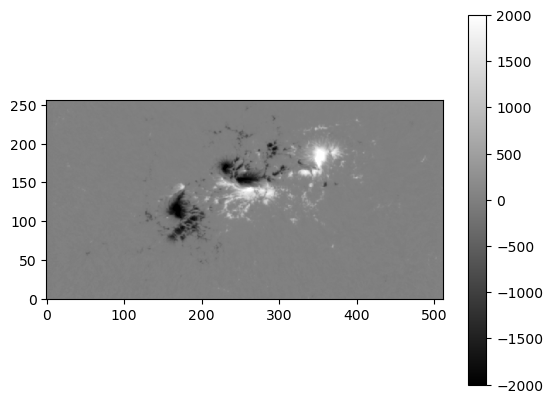

In [18]:
plt.imshow(Bp[0, :, :, 0].T, origin="lower", cmap="gray", vmin=-vmm, vmax=vmm)
plt.colorbar()
plt.show()

plt.imshow(Bp[1, :, :, 0].T, origin="lower", cmap="gray", vmin=-vmm, vmax=vmm)
plt.colorbar()
plt.show()

plt.imshow(Bp[2, :, :, 0].T, origin="lower", cmap="gray", vmin=-vmm, vmax=vmm)
plt.colorbar()
plt.show()

In [28]:
from numba import njit

In [93]:
@njit
def greenpot(bz, nx, ny, dz=0.1):
    """
    function: greenpot

    This function extrapolates the potential magnetic field using Green's functions.
    The underlying assuption of a potential field is that it is Maxwell-stress free.
    The monopole depth is 0.01 pixels.
    """
    print('Calculating the potential field. This takes a minute.')

    nnx = nx
    nny = ny
    
    # define the monopole depth, dz
    dz = dz

    # malloc some arrays
    pfpot      = np.zeros((nny,nnx))
    rdist      = np.zeros((nny,nnx))
    bztmp      = np.zeros((nny,nnx))
    bxp        = np.zeros((nny,nnx))
    byp        = np.zeros((nny,nnx))

    # substitute zeros for nans in bz
    for iny in range(nny):
        for inx in range(nnx):
            if np.isnan(bz[iny,inx]):
                bztmp[iny,inx] = 0.0
            else:
                bztmp[iny,inx] = bz[iny,inx]

    rdd  = 0.0
    rdd1 = 0.0
    rdd2 = 0.0
    for iny in range(nny):
        for inx in range(nnx):
            rdd1  = float(inx)
            rdd2  = float(iny)
            rdd   = rdd1 * rdd1 + rdd2 * rdd2 + dz * dz
            rdist[iny,inx] = 1.0/(np.sqrt(rdd))

    iwindow = 0
    if (nnx > nny):
        iwindow = nnx
    else:
        iwindow = nny

    rwindow = float(iwindow)
    rwindow = rwindow * rwindow + 0.01 # must be square    
    rwindow = 1.0e2                    # limit the window size to be 10.    
    rwindow = np.sqrt(rwindow)
    iwindow = int(rwindow)

    for iny in range(nny):
        for inx in range(nnx):
            if np.isnan(bz[iny,inx]):
                pfpot[iny,inx] = 0.0
            else:
                sum = 0.0
                j2s = iny - iwindow
                j2e = iny + iwindow
                if (j2s < 0):
                    j2s = 0
                if (j2e > nny):
                    j2e = nny
                i2s = inx - iwindow
                i2e = inx + iwindow
                if (i2s < 0):
                    i2s = 0
                if (i2e > nnx):
                    i2e = nnx
                for j2 in range(j2s,j2e):
                    for i2 in range(i2s,i2e):
                        val1 = bztmp[j2,i2]
                        di = abs(i2 - inx)
                        dj = abs(j2 - iny)
                        sum = sum + val1 * rdist[dj,di] * dz
                pfpot[iny,inx] = sum
    
    for iny in range(1,nny-1):
        for inx in range(1,nnx-1):
            bxp[iny,inx] = -(pfpot[iny,inx+1] - pfpot[iny,inx-1])*0.5
            byp[iny,inx] = -(pfpot[iny+1,inx] - pfpot[iny-1,inx])*0.5

    return [bxp, byp]

In [94]:
bzz = B[2, :, :, 0].T
bzz.shape

(256, 512)

In [95]:
nx = bzz.shape[1]
ny = bzz.shape[0]

nx, ny

(512, 256)

In [138]:
start_time = time()
bpx, bpy = greenpot(bzz, nx, ny, dz=0.1)
print(f"{time() - start_time} seconds")

Calculating the potential field. This takes a minute.
0.060289621353149414 seconds


In [139]:
bpx.shape

(256, 512)

In [140]:
bpy.shape

(256, 512)

In [141]:
bpx = bpx.T
bpy = bpy.T

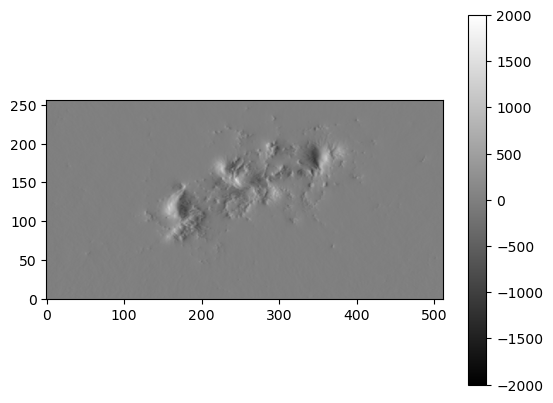

In [142]:
plt.imshow(bpx.T, origin="lower", cmap="gray", vmin=-vmm, vmax=vmm)
plt.colorbar()

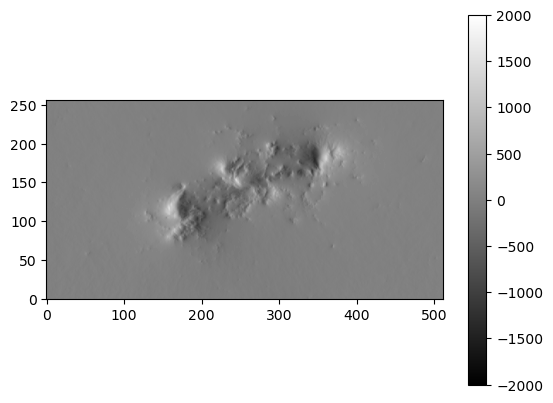

In [144]:
plt.imshow(Bp[0, :, :, 0].T, origin="lower", cmap="gray", vmin=-vmm, vmax=vmm)
plt.colorbar()
plt.show()

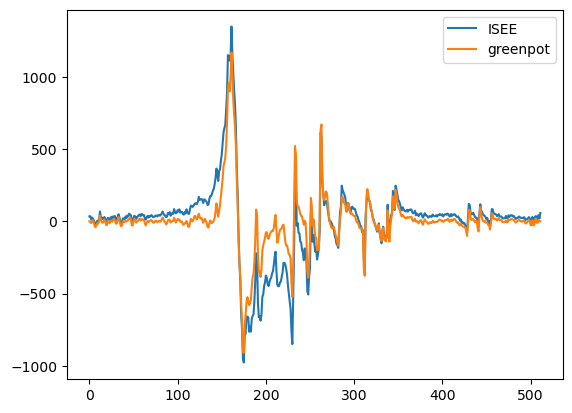

In [143]:
plt.plot(Bp[0, :, 120, 0].flatten(), label='ISEE')
plt.plot(bpx[:, 120].flatten(), label='greenpot')
plt.legend()
plt.show()

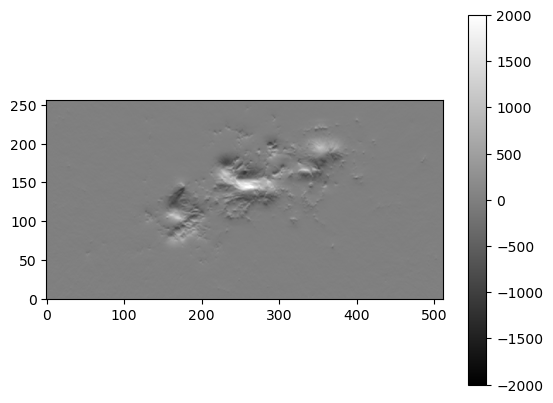

In [147]:
plt.imshow(bpy.T, origin="lower", cmap="gray", vmin=-vmm, vmax=vmm)
plt.colorbar()

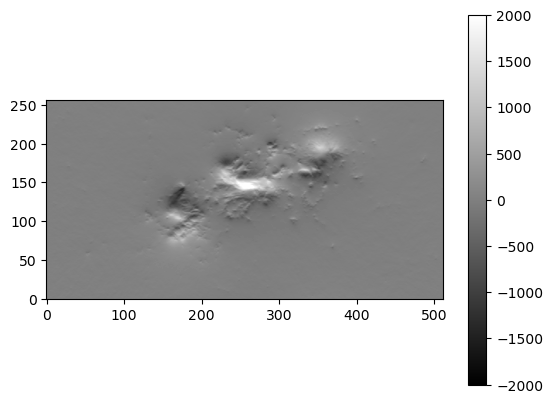

In [148]:
plt.imshow(Bp[1, :, :, 0].T, origin="lower", cmap="gray", vmin=-vmm, vmax=vmm)
plt.colorbar()
plt.show()

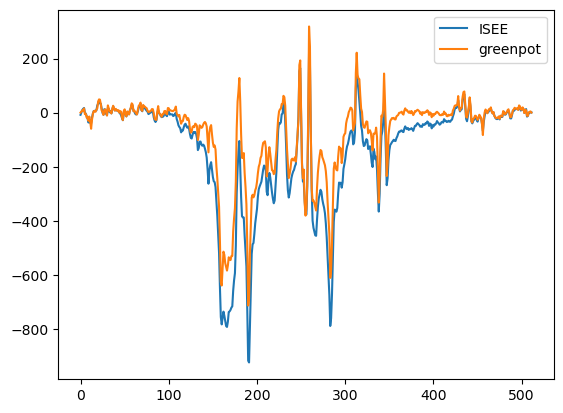

In [149]:
plt.plot(Bp[1, :, 120, 0].flatten(), label='ISEE')
plt.plot(bpy[:, 120].flatten(), label='greenpot')
plt.legend()
plt.show()